## Task 1 — Real-Time Crowd Monitoring Using Webcam

In this task, the laptop’s built-in webcam is used as a live video source to
simulate a CCTV feed. Video frames are captured continuously and processed
in real time using a YOLO + CSRNet hybrid model.

YOLO is used for accurate person detection and crowd counting, while CSRNet
is used to visualize crowd density through heatmap overlays. A threshold-based
alert mechanism is implemented to detect overcrowding situations.

This setup demonstrates real-time crowd monitoring without requiring
physical CCTV hardware and fulfills the live-stream requirements of
Milestone 3.

In [44]:
%matplotlib inline

Imports & Setup

In [ ]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import gradio as gr

from torchvision import models

Load CSRNet Architecture

In [ ]:
# ======================================================
# CSRNet Architecture  
# ======================================================

class CSRNet(nn.Module):
    def __init__(self, load_pretrained_vgg=False):
        super().__init__()

        if load_pretrained_vgg:
            from torchvision.models import VGG16_Weights
            vgg = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        else:
            vgg = models.vgg16(weights=None)

        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, 3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
        )

        self.output_layer = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        x = self.output_layer(x)
        return x


Load Fine-Tuned CSRNet Weights

In [23]:
# ======================================================
# Load Fine-Tuned CSRNet
# ======================================================

DEVICE = torch.device("cpu")

csrnet = CSRNet(load_pretrained_vgg=False).to(DEVICE)
state = torch.load("csrnet_finetuned.pth", map_location="cpu")
csrnet.load_state_dict(state)
csrnet.eval()

print("Fine-tuned CSRNet loaded")

Fine-tuned CSRNet loaded


In [6]:
!pip install ultralytics

  Using cached ultralytics-8.3.240-py3-none-any.whl.metadata (37 kB)
  Using cached polars-1.36.1-py3-none-any.whl.metadata (10 kB)
  Using cached ultralytics_thop-2.0.18-py3-none-any.whl.metadata (14 kB)
  Using cached polars_runtime_32-1.36.1-cp39-abi3-win_amd64.whl.metadata (1.5 kB)
Using cached ultralytics-8.3.240-py3-none-any.whl (1.1 MB)
Using cached polars-1.36.1-py3-none-any.whl (802 kB)
Using cached polars_runtime_32-1.36.1-cp39-abi3-win_amd64.whl (44.5 MB)
Using cached ultralytics_thop-2.0.18-py3-none-any.whl (28 kB)

   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-runtime-32]
   ---------------------------------------- 0/4 [polars-ru

Load YOLOv8 (Person Detector)

In [24]:
# ======================================================
# Load YOLOv8 (Person Detection)
# ======================================================

from ultralytics import YOLO

yolo = YOLO("yolov8n.pt")  # lightweight & accurate
print("YOLOv8 loaded")


YOLOv8 loaded


Preprocessing for CSRNet

In [25]:
# ======================================================
# Preprocessing
# ======================================================

def preprocess_for_csrnet(frame_bgr):
    frame = cv2.resize(frame_bgr, (1024, 768))
    frame = frame.astype(np.float32) / 255.0
    frame = torch.from_numpy(frame.transpose(2, 0, 1)).unsqueeze(0)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

    frame = (frame - mean) / std
    return frame.to(DEVICE)


YOLO + CSRNet Hybrid Inference

In [26]:
# ======================================================
# Hybrid Inference
# ======================================================

def hybrid_inference(frame_bgr):
    # YOLO detection
    results = yolo(frame_bgr, conf=0.4, classes=[0])[0]
    person_count = len(results.boxes)

    # Draw YOLO boxes
    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(frame_bgr, (x1,y1), (x2,y2), (0,255,0), 2)

    # CSRNet density
    inp = preprocess_for_csrnet(frame_bgr)
    with torch.no_grad():
        density = csrnet(inp)[0,0].cpu().numpy()

    density = cv2.GaussianBlur(density, (0,0), 3)
    density_up = cv2.resize(density, (frame_bgr.shape[1], frame_bgr.shape[0]))

    # Heatmap
    dm_norm = density_up / (density_up.max() + 1e-6)
    heatmap = cv2.applyColorMap(np.uint8(255 * dm_norm), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap, 0.4, 0)

    return overlay, person_count

AUTO-SWITCH DECISION FUNCTION

In [ ]:
# ======================================================
# Auto-Switch Logic: YOLO ↔ CSRNet
# ======================================================

YOLO_THRESHOLD_LOW = 8     # sparse crowd
YOLO_THRESHOLD_HIGH = 20  # dense crowd

def auto_switch_inference(frame_bgr):
    """
    Dynamically choose YOLO or CSRNet based on crowd density
    """

    # Step 1: YOLO quick estimate
    yolo_results = yolo(frame_bgr, conf=0.4, classes=[0])[0]
    yolo_count = len(yolo_results.boxes)

    # Draw YOLO boxes (optional)
    yolo_vis = frame_bgr.copy()
    for box in yolo_results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(yolo_vis, (x1,y1), (x2,y2), (0,255,0), 2)

    # Step 2: Decide mode
    if yolo_count <= YOLO_THRESHOLD_LOW:
        mode = "YOLO_ONLY"
        final_count = yolo_count
        output_frame = yolo_vis

    else:
        # CSRNet inference
        inp = preprocess_for_csrnet(frame_bgr)
        with torch.no_grad():
            density = csrnet(inp)[0,0].cpu().numpy()

        density = cv2.GaussianBlur(density, (0,0), 3)
        density_up = cv2.resize(
            density,
            (frame_bgr.shape[1], frame_bgr.shape[0])
        )

        csr_count = density_up.sum()

        dm_norm = density_up / (density_up.max() + 1e-6)
        heatmap = cv2.applyColorMap(
            np.uint8(255 * dm_norm),
            cv2.COLORMAP_JET
        )

        overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap, 0.4, 0)

        if yolo_count <= YOLO_THRESHOLD_HIGH:
            mode = "HYBRID"
            final_count = yolo_count
        else:
            mode = "CSRNET_ONLY"
            final_count = int(csr_count)

        output_frame = overlay

    return output_frame, final_count, mode
print("Auto-switch thresholds:")
print(f"YOLO only ≤ {YOLO_THRESHOLD_LOW}")
print(f"Hybrid ≤ {YOLO_THRESHOLD_HIGH}")
print("CSRNet only > threshold")

Auto-switch thresholds:
YOLO only ≤ 8
Hybrid ≤ 20
CSRNet only > threshold



0: 384x640 15 persons, 215.9ms
Speed: 71.3ms preprocess, 215.9ms inference, 7.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 persons, 637.7ms
Speed: 52.7ms preprocess, 637.7ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 23 persons, 182.6ms
Speed: 66.0ms preprocess, 182.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 24 persons, 203.1ms
Speed: 32.2ms preprocess, 203.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 179.8ms
Speed: 12.6ms preprocess, 179.8ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 32 persons, 187.2ms
Speed: 34.0ms preprocess, 187.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


CSRNet vs YOLO Comparison


0: 480x640 27 persons, 188.1ms
Speed: 8.9ms preprocess, 188.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


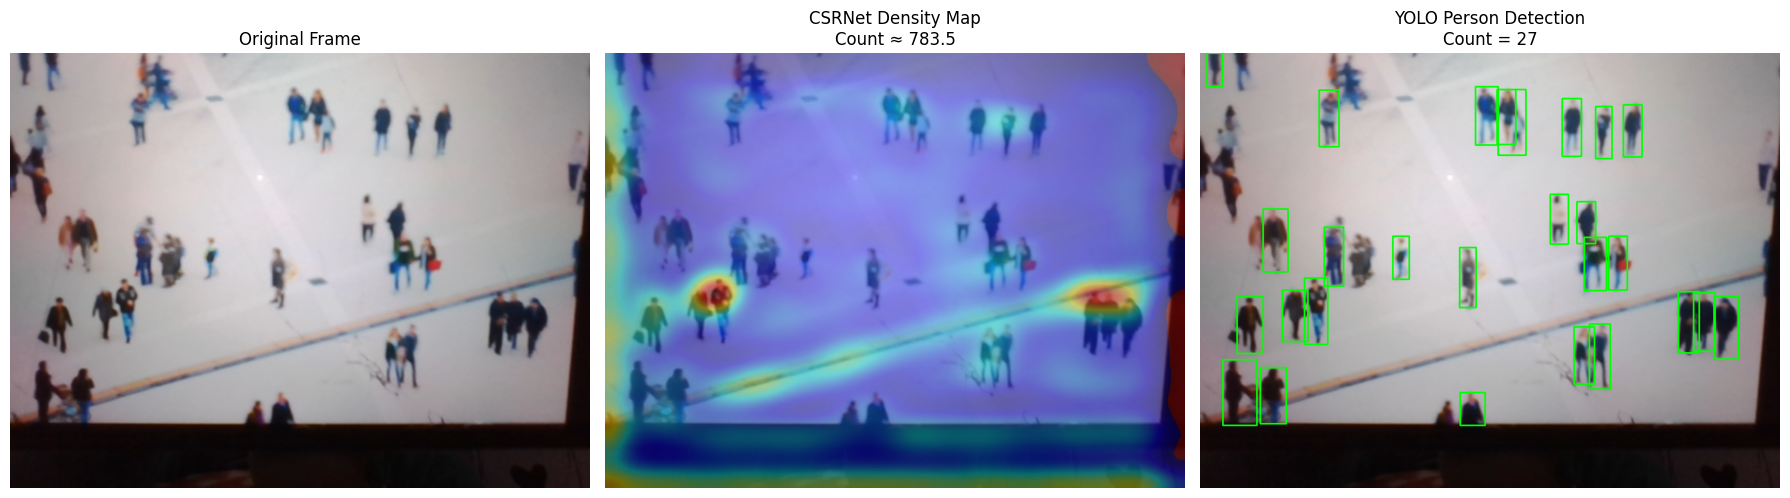

In [34]:
# ======================================================
# CSRNet vs YOLO — Side-by-Side Comparison
# ======================================================

def csrnet_only_inference(frame_bgr):
    inp = preprocess_for_csrnet(frame_bgr)
    with torch.no_grad():
        density = csrnet(inp)[0, 0].cpu().numpy()

    density = cv2.GaussianBlur(density, (0,0), 3)
    density_up = cv2.resize(density, (frame_bgr.shape[1], frame_bgr.shape[0]))

    count = density_up.sum()

    dm_norm = density_up / (density_up.max() + 1e-6)
    heatmap = cv2.applyColorMap(np.uint8(255 * dm_norm), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(frame_bgr, 0.6, heatmap, 0.4, 0)

    return overlay, count


def yolo_only_inference(frame_bgr):
    results = yolo(frame_bgr, conf=0.4, classes=[0])[0]
    count = len(results.boxes)

    vis = frame_bgr.copy()
    for box in results.boxes.xyxy.cpu().numpy():
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(vis, (x1,y1), (x2,y2), (0,255,0), 2)

    return vis, count


# Capture one webcam frame
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

frame = cv2.resize(frame, (1024, 768))

csrnet_vis, csrnet_count = csrnet_only_inference(frame)
yolo_vis, yolo_count = yolo_only_inference(frame)

# Plot comparison
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.title("Original Frame")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title(f"CSRNet Density Map\nCount ≈ {csrnet_count:.1f}")
plt.imshow(cv2.cvtColor(csrnet_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"YOLO Person Detection\nCount = {yolo_count}")
plt.imshow(cv2.cvtColor(yolo_vis, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


Numeric Comparison Table

In [35]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Method": ["CSRNet", "YOLO"],
    "Estimated Count": [round(csrnet_count, 1), yolo_count],
    "Strength": [
        "Dense crowd estimation",
        "Accurate individual detection"
    ]
})

comparison_df

Method  Estimated Count                       Strength
0  CSRNet            783.5         Dense crowd estimation
1    YOLO             27.0  Accurate individual detection

Gradio Interface (Final Milestone Output)

In [45]:
# ======================================================
# Gradio Interface
# ======================================================

def process_frame(frame_rgb):
    frame_bgr = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)

    vis, count, mode = auto_switch_inference(frame_bgr)

    status = f"Mode: {mode} | Count: {count}"

    if count > 15:
        status = f"⚠ ALERT: High Crowd ({count}) | Mode: {mode}"

    return cv2.cvtColor(vis, cv2.COLOR_BGR2RGB), status


gr.Interface(
    fn=process_frame,
    inputs=gr.Image(sources=["webcam"], streaming=True),
    outputs=[
        gr.Image(label="YOLO + CSRNet Visualization"),
        gr.Textbox(label="Crowd Status")
    ],
    title="YOLO + CSRNet Hybrid Crowd Monitoring",
    description="YOLO for accurate counting, CSRNet for density visualization.",
    live=True
).launch(share=True)

* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://e27cd556e707303dea.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Task 2 — CCTV Video File Processing

In this task, a pre-recorded MP4 video is processed frame-by-frame to simulate
a live CCTV feed.

### Workflow:
1. Video frames are read sequentially using OpenCV
2. Each frame is processed using a YOLO + CSRNet hybrid pipeline
3. YOLO provides accurate person counts
4. CSRNet provides density visualization
5. Threshold-based alerts are generated
6. The annotated output is saved as a new video file

This approach replicates real-world CCTV analytics on recorded footage.


Video File Configuration

In [46]:
# ======================================================
# Task 2 — Video File Configuration
# ======================================================

VIDEO_INPUT_PATH = "C:\\Users\\ARTI\\OneDrive\\Desktop\\projects\\cd\\video_input1.mp4"   
VIDEO_OUTPUT_PATH = "output_crowd_annotated.mp4"

ALERT_THRESHOLD = 10    # number of people for alert

Video Processing Function (Core Logic)

In [47]:
# ======================================================
# Task 2 — Process Video File (YOLO + CSRNet)
# ======================================================

def process_video_file(
    input_path,
    output_path,
    alert_threshold=10,
    display_preview=True
):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video file: {input_path}")

    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps    = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        overlay, count = hybrid_inference(frame)

        # Alert text
        if count >= alert_threshold:
            alert_text = f"ALERT: Crowd={count}"
            color = (0, 0, 255)
        else:
            alert_text = f"People: {count}"
            color = (0, 255, 0)

        # Draw overlay text
        cv2.putText(
            overlay,
            alert_text,
            (20, 40),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.0,
            color,
            2
        )

        out.write(overlay)

        # Optional preview inside notebook
        if display_preview and frame_idx % 30 == 0:
            plt.figure(figsize=(6,4))
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"Frame {frame_idx}")
            plt.axis("off")
            plt.show()

        frame_idx += 1

    cap.release()
    out.release()

    print("Video processing complete.")
    print(f"Saved annotated video to: {output_path}")

Run Video Processing (Execution Cell)


0: 384x640 7 persons, 1855.3ms
Speed: 57.6ms preprocess, 1855.3ms inference, 28.5ms postprocess per image at shape (1, 3, 384, 640)


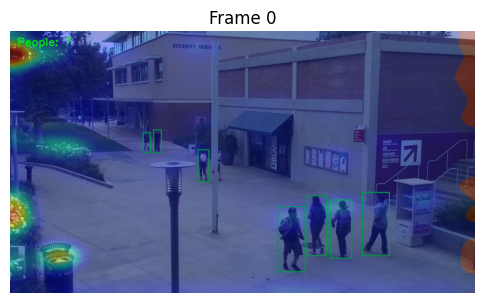


0: 384x640 7 persons, 707.4ms
Speed: 46.5ms preprocess, 707.4ms inference, 13.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 930.8ms
Speed: 22.5ms preprocess, 930.8ms inference, 5.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 2515.0ms
Speed: 11.7ms preprocess, 2515.0ms inference, 11.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1283.1ms
Speed: 27.8ms preprocess, 1283.1ms inference, 7.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 561.5ms
Speed: 9.0ms preprocess, 561.5ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1664.4ms
Speed: 28.7ms preprocess, 1664.4ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1678.4ms
Speed: 48.3ms preprocess, 1678.4ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 594.6ms
Speed: 28.4ms preprocess, 594.6ms inference, 12.5

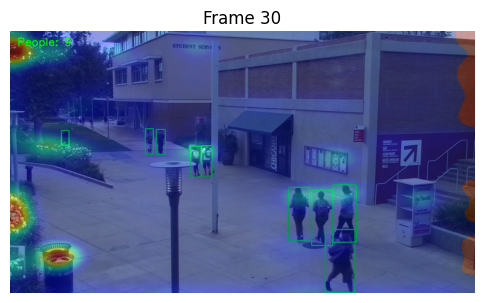


0: 384x640 9 persons, 542.1ms
Speed: 108.3ms preprocess, 542.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 514.7ms
Speed: 18.2ms preprocess, 514.7ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 358.7ms
Speed: 10.6ms preprocess, 358.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 559.2ms
Speed: 12.4ms preprocess, 559.2ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 496.3ms
Speed: 24.8ms preprocess, 496.3ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 556.4ms
Speed: 30.0ms preprocess, 556.4ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1045.1ms
Speed: 8.1ms preprocess, 1045.1ms inference, 18.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 508.9ms
Speed: 23.8ms preprocess, 508.9ms inference, 4.0ms postp

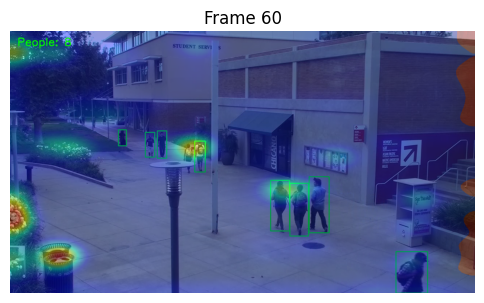


0: 384x640 8 persons, 1590.3ms
Speed: 37.8ms preprocess, 1590.3ms inference, 10.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 295.0ms
Speed: 26.9ms preprocess, 295.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 644.4ms
Speed: 11.4ms preprocess, 644.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 481.6ms
Speed: 32.0ms preprocess, 481.6ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 552.9ms
Speed: 12.1ms preprocess, 552.9ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 374.2ms
Speed: 5.5ms preprocess, 374.2ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 468.1ms
Speed: 5.6ms preprocess, 468.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 511.5ms
Speed: 35.4ms preprocess, 511.5ms inference, 2.8ms postpro

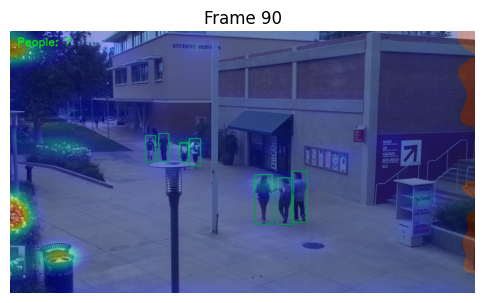


0: 384x640 7 persons, 582.0ms
Speed: 30.0ms preprocess, 582.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 1146.2ms
Speed: 9.0ms preprocess, 1146.2ms inference, 74.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 398.8ms
Speed: 5.7ms preprocess, 398.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 398.8ms
Speed: 10.2ms preprocess, 398.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 643.0ms
Speed: 17.1ms preprocess, 643.0ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 235.1ms
Speed: 6.3ms preprocess, 235.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 479.7ms
Speed: 10.8ms preprocess, 479.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 494.6ms
Speed: 10.5ms preprocess, 494.6ms inference, 3.5ms postproc

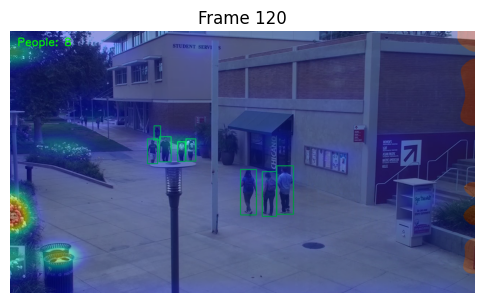


0: 384x640 7 persons, 625.0ms
Speed: 7.5ms preprocess, 625.0ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 484.3ms
Speed: 35.9ms preprocess, 484.3ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 389.0ms
Speed: 6.8ms preprocess, 389.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 488.8ms
Speed: 29.4ms preprocess, 488.8ms inference, 11.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 411.3ms
Speed: 12.2ms preprocess, 411.3ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 392.4ms
Speed: 10.1ms preprocess, 392.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 383.2ms
Speed: 5.5ms preprocess, 383.2ms inference, 14.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 542.3ms
Speed: 13.6ms preprocess, 542.3ms inference, 2.7ms postproce

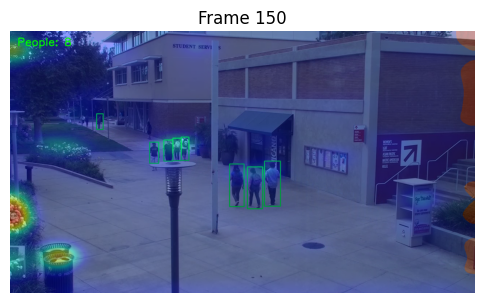


0: 384x640 8 persons, 476.8ms
Speed: 115.2ms preprocess, 476.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 492.6ms
Speed: 34.6ms preprocess, 492.6ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 294.8ms
Speed: 33.6ms preprocess, 294.8ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 591.9ms
Speed: 8.4ms preprocess, 591.9ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 489.2ms
Speed: 23.1ms preprocess, 489.2ms inference, 4.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 370.4ms
Speed: 20.0ms preprocess, 370.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 668.0ms
Speed: 15.0ms preprocess, 668.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 489.9ms
Speed: 18.4ms preprocess, 489.9ms inference, 2.4ms postproc

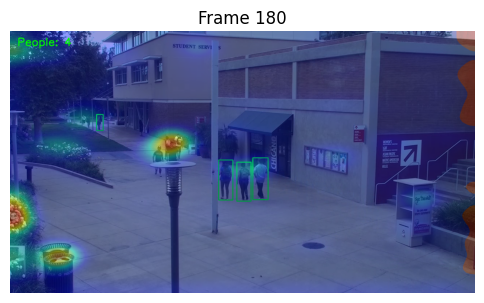


0: 384x640 4 persons, 248.5ms
Speed: 9.1ms preprocess, 248.5ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 486.5ms
Speed: 10.2ms preprocess, 486.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 457.3ms
Speed: 11.6ms preprocess, 457.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 500.4ms
Speed: 9.8ms preprocess, 500.4ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 515.8ms
Speed: 19.3ms preprocess, 515.8ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 509.1ms
Speed: 11.6ms preprocess, 509.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 526.2ms
Speed: 10.7ms preprocess, 526.2ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 251.5ms
Speed: 6.0ms preprocess, 251.5ms inference, 2.9ms postprocess

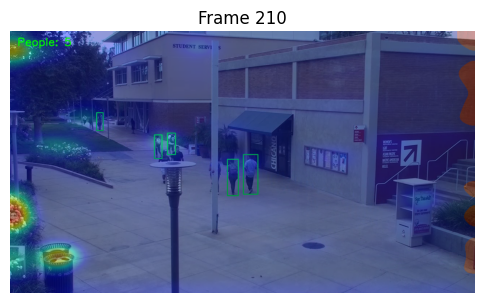


0: 384x640 5 persons, 505.5ms
Speed: 16.0ms preprocess, 505.5ms inference, 4.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 420.0ms
Speed: 41.2ms preprocess, 420.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 566.0ms
Speed: 6.4ms preprocess, 566.0ms inference, 8.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 518.6ms
Speed: 11.0ms preprocess, 518.6ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 1949.5ms
Speed: 12.1ms preprocess, 1949.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 2174.0ms
Speed: 6.0ms preprocess, 2174.0ms inference, 16.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 442.5ms
Speed: 17.4ms preprocess, 442.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 904.0ms
Speed: 9.4ms preprocess, 904.0ms inference, 6.0ms postpr

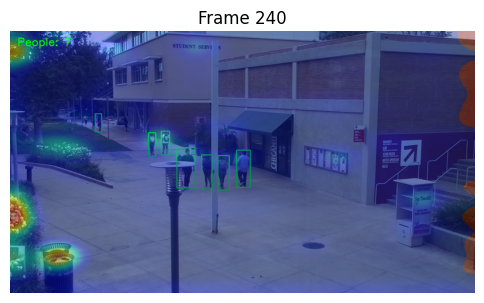


0: 384x640 6 persons, 593.5ms
Speed: 8.4ms preprocess, 593.5ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 459.9ms
Speed: 29.8ms preprocess, 459.9ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 428.8ms
Speed: 11.1ms preprocess, 428.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 525.7ms
Speed: 16.1ms preprocess, 525.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 1179.7ms
Speed: 15.8ms preprocess, 1179.7ms inference, 38.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 524.1ms
Speed: 20.8ms preprocess, 524.1ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 511.3ms
Speed: 9.8ms preprocess, 511.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 499.2ms
Speed: 29.4ms preprocess, 499.2ms inference, 3.2ms postpro

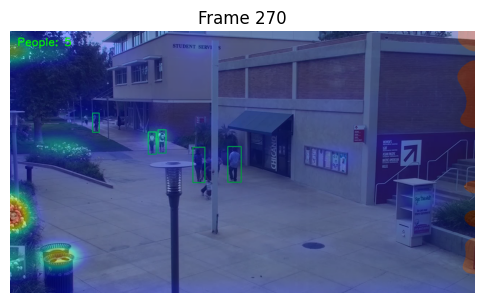


0: 384x640 6 persons, 555.3ms
Speed: 14.9ms preprocess, 555.3ms inference, 4.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 400.5ms
Speed: 6.7ms preprocess, 400.5ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 487.2ms
Speed: 10.5ms preprocess, 487.2ms inference, 6.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 468.5ms
Speed: 9.0ms preprocess, 468.5ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 408.0ms
Speed: 32.7ms preprocess, 408.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 601.2ms
Speed: 19.8ms preprocess, 601.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 505.2ms
Speed: 8.3ms preprocess, 505.2ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 700.8ms
Speed: 47.8ms preprocess, 700.8ms inference, 3.7ms postprocess

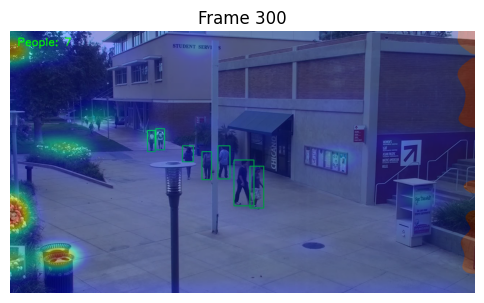


0: 384x640 7 persons, 593.3ms
Speed: 5.9ms preprocess, 593.3ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 401.8ms
Speed: 13.1ms preprocess, 401.8ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 649.4ms
Speed: 19.7ms preprocess, 649.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 581.5ms
Speed: 12.6ms preprocess, 581.5ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 528.8ms
Speed: 23.8ms preprocess, 528.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 306.3ms
Speed: 6.1ms preprocess, 306.3ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 479.1ms
Speed: 28.6ms preprocess, 479.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 503.4ms
Speed: 8.7ms preprocess, 503.4ms inference, 2.5ms postprocess

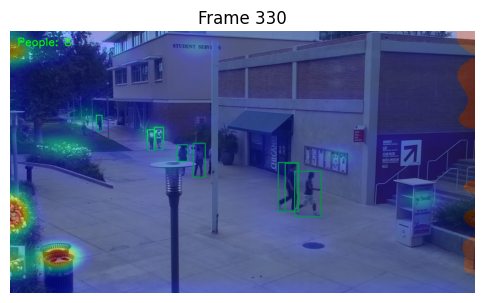


0: 384x640 8 persons, 712.4ms
Speed: 8.7ms preprocess, 712.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 506.6ms
Speed: 22.5ms preprocess, 506.6ms inference, 3.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 562.0ms
Speed: 12.1ms preprocess, 562.0ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 250.2ms
Speed: 8.4ms preprocess, 250.2ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 588.2ms
Speed: 9.6ms preprocess, 588.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 407.8ms
Speed: 10.2ms preprocess, 407.8ms inference, 3.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 485.4ms
Speed: 10.4ms preprocess, 485.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 645.1ms
Speed: 17.8ms preprocess, 645.1ms inference, 2.4ms postprocess

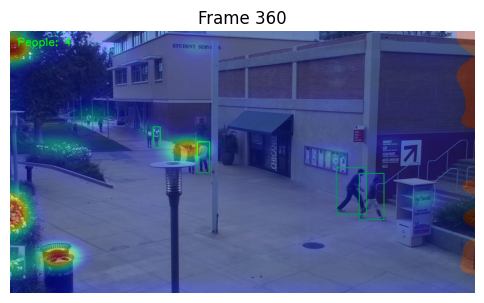


0: 384x640 5 persons, 598.6ms
Speed: 12.8ms preprocess, 598.6ms inference, 3.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 266.0ms
Speed: 7.7ms preprocess, 266.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 519.4ms
Speed: 10.7ms preprocess, 519.4ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 553.8ms
Speed: 10.2ms preprocess, 553.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 564.4ms
Speed: 8.9ms preprocess, 564.4ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 348.2ms
Speed: 11.2ms preprocess, 348.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 693.2ms
Speed: 10.0ms preprocess, 693.2ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 469.8ms
Speed: 14.8ms preprocess, 469.8ms inference, 2.4ms postproces

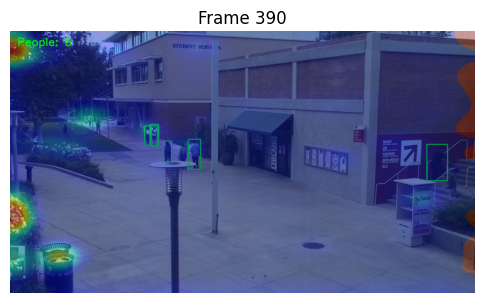


0: 384x640 3 persons, 272.4ms
Speed: 5.2ms preprocess, 272.4ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 642.1ms
Speed: 9.3ms preprocess, 642.1ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 578.8ms
Speed: 6.2ms preprocess, 578.8ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 462.3ms
Speed: 19.4ms preprocess, 462.3ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 586.4ms
Speed: 16.9ms preprocess, 586.4ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 496.7ms
Speed: 14.4ms preprocess, 496.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 466.9ms
Speed: 11.5ms preprocess, 466.9ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 268.1ms
Speed: 13.2ms preprocess, 268.1ms inference, 2.3ms postprocess

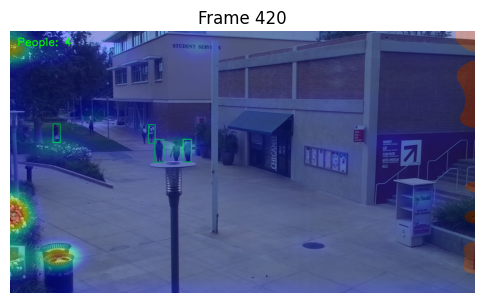


0: 384x640 3 persons, 559.4ms
Speed: 10.3ms preprocess, 559.4ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 546.5ms
Speed: 23.0ms preprocess, 546.5ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 374.5ms
Speed: 10.6ms preprocess, 374.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 565.7ms
Speed: 21.1ms preprocess, 565.7ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 430.3ms
Speed: 5.6ms preprocess, 430.3ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 521.3ms
Speed: 10.8ms preprocess, 521.3ms inference, 4.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 227.0ms
Speed: 5.5ms preprocess, 227.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 581.4ms
Speed: 16.8ms preprocess, 581.4ms inference, 2.4ms postproce

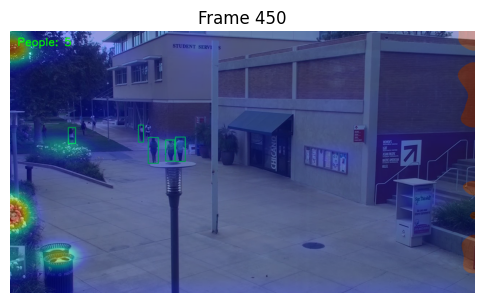


0: 384x640 6 persons, 566.8ms
Speed: 9.8ms preprocess, 566.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 7 persons, 539.6ms
Speed: 10.1ms preprocess, 539.6ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 302.6ms
Speed: 11.9ms preprocess, 302.6ms inference, 5.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 2408.6ms
Speed: 12.0ms preprocess, 2408.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 478.1ms
Speed: 6.1ms preprocess, 478.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 445.0ms
Speed: 6.7ms preprocess, 445.0ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 490.8ms
Speed: 17.7ms preprocess, 490.8ms inference, 5.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 499.6ms
Speed: 8.5ms preprocess, 499.6ms inference, 3.8ms postproces

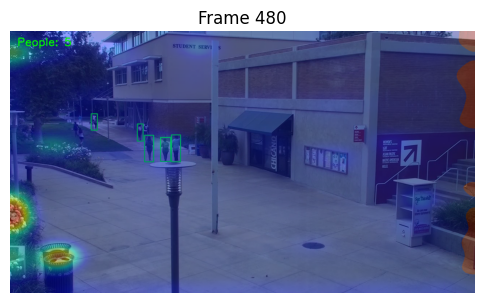


0: 384x640 5 persons, 637.3ms
Speed: 7.7ms preprocess, 637.3ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 503.5ms
Speed: 8.3ms preprocess, 503.5ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 231.4ms
Speed: 5.8ms preprocess, 231.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 482.4ms
Speed: 22.8ms preprocess, 482.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 500.2ms
Speed: 21.7ms preprocess, 500.2ms inference, 4.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 1024.4ms
Speed: 97.5ms preprocess, 1024.4ms inference, 5.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 242.8ms
Speed: 8.9ms preprocess, 242.8ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 514.4ms
Speed: 56.4ms preprocess, 514.4ms inference, 2.4ms postproces

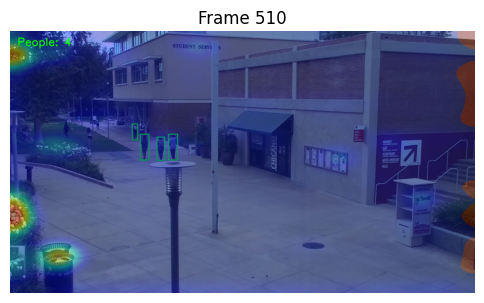


0: 384x640 4 persons, 644.2ms
Speed: 32.9ms preprocess, 644.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 531.1ms
Speed: 20.6ms preprocess, 531.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 559.4ms
Speed: 20.7ms preprocess, 559.4ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 248.4ms
Speed: 10.4ms preprocess, 248.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 557.5ms
Speed: 8.7ms preprocess, 557.5ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 4 persons, 469.8ms
Speed: 13.6ms preprocess, 469.8ms inference, 7.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 355.9ms
Speed: 34.0ms preprocess, 355.9ms inference, 7.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 691.7ms
Speed: 11.3ms preprocess, 691.7ms inference, 3.3ms postproce

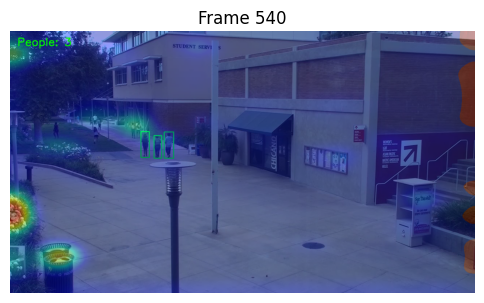


0: 384x640 3 persons, 772.8ms
Speed: 13.6ms preprocess, 772.8ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 245.1ms
Speed: 8.8ms preprocess, 245.1ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 499.4ms
Speed: 21.4ms preprocess, 499.4ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 527.1ms
Speed: 23.0ms preprocess, 527.1ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 1311.1ms
Speed: 10.0ms preprocess, 1311.1ms inference, 5.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 313.4ms
Speed: 7.9ms preprocess, 313.4ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 525.0ms
Speed: 23.7ms preprocess, 525.0ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 persons, 422.0ms
Speed: 24.3ms preprocess, 422.0ms inference, 2.4ms postproc

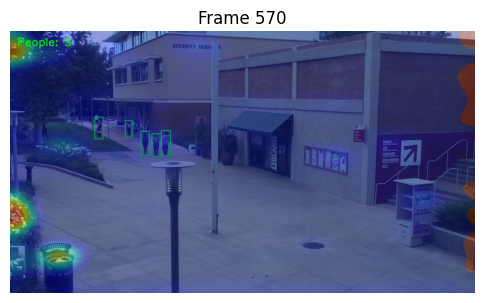


0: 384x640 6 persons, 612.6ms
Speed: 5.5ms preprocess, 612.6ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 302.9ms
Speed: 11.2ms preprocess, 302.9ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 711.2ms
Speed: 7.7ms preprocess, 711.2ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 570.0ms
Speed: 10.5ms preprocess, 570.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 515.8ms
Speed: 10.4ms preprocess, 515.8ms inference, 2.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 510.9ms
Speed: 11.8ms preprocess, 510.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 persons, 719.3ms
Speed: 19.3ms preprocess, 719.3ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 6 persons, 517.2ms
Speed: 11.1ms preprocess, 517.2ms inference, 5.7ms postproces

In [48]:
# ======================================================
# Task 2 — Run Video Processing
# ======================================================

process_video_file(
    input_path=VIDEO_INPUT_PATH,
    output_path=VIDEO_OUTPUT_PATH,
    alert_threshold=ALERT_THRESHOLD,
    display_preview=True   # shows sample frames in notebook
)
